This notebooks uses the dataset from 'Persistent Homology for the Quantitative Evaluation of Architectural Features in Prostate Cancer Histology' by Lawson et al.   
https://doi.org/10.1038/s41598-018-36798-y

Download the original dataset from https://osf.io/k96qw  

Alternatively, precomputed ECCs and ECPs can be found as pickle files at  
https://drive.google.com/drive/folders/1Nn93YWzY0ErW__KhVjmYulxConODOoYP?usp=sharing

In [ ]:
! git clone --recursive https://github.com/dgurnari/pyEulerCurves.git -q
! pip install ./pyEulerCurves -q

In [ ]:
! pip install histomicstk --find-links https://girder.github.io/large_image_wheels -q

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

## Compute ECC from grayscale images

In [ ]:
# Load labels
labels = pd.read_csv('osfstorage-archive/rois-with-grade.csv')
labels

,roi_label,grade
0,1_1,3
1,1_2,3
2,1_3,3
3,1_4,3
4,1_5,3
...,...,...
5177,15_270,3
5178,15_271,3
5179,15_272,3
5180,15_273,3


In [ ]:
from PIL import Image, ImageOps
import pickle
import pyEulerCurves as pyecc

trans = pyecc.ECC_from_bitmap(periodic_boundary=False, 
                              workers=2    # number of CPU cores
                              )

# Load and preprocess the images
# https://digitalslidearchive.github.io/HistomicsTK/examples/color_normalization_and_augmentation.html
import histomicstk as htk

# color norm. standard (from TCGA-A2-A3XS-DX1, Amgad et al, 2019)
cnorm = {
    'mu': np.array([8.74108109, -0.12440419,  0.0444982]),
    'sigma': np.array([0.6135447, 0.10989545, 0.0286032]),
}

ECC_grayscale = []

for i, row in tqdm(labels.iterrows()):
    temp = Image.open('pkls/rois/{}.tiff'.format(row.roi_label))
    tissue_rgb = np.array(temp)
    temp.close()
    tissue_rgb_normalized = htk.preprocessing.color_normalization.reinhard(tissue_rgb, 
                                                                           target_mu=cnorm['mu'], 
                                                                           target_sigma=cnorm['sigma'])

    grayscale_img = ImageOps.grayscale(Image.fromarray(tissue_rgb_normalized, mode='RGB'))
    ECC_grayscale.append([trans.fit_transform(np.array(grayscale_img).astype(np.uint16)),
                          row.grade])

with open('pkls/ECC_grayscale.pkl', 'wb') as f:
    pickle.dump(ECC_grayscale, f)

0it [00:00, ?it/s]

## Compute ECC from H&E channels

In [ ]:
# load pickle
import pickle as pkl

with open('pkls/processed_data.pkl','rb') as f:
    data = pkl.load(f)

Text(0.5, 1.0, 'eosin')

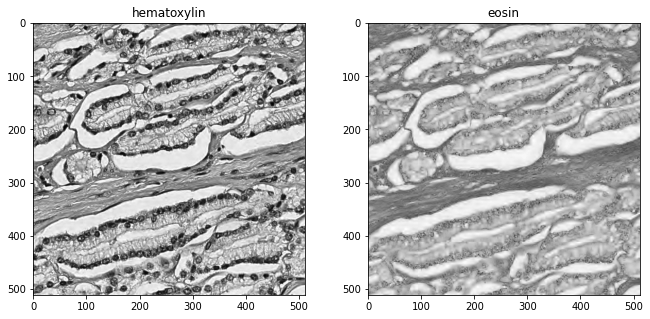

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(11,5))

axs[0].imshow(data[0][0][:, :, 0], cmap='gray')
axs[0].set_title('hematoxylin')
axs[1].imshow(data[0][0][:, :, 1], cmap='gray')
axs[1].set_title('eosin')

In [ ]:
import pyEulerCurves as pyecc

In [ ]:
trans = pyecc.ECC_from_bitmap(periodic_boundary=False, 
                              workers=2    # number of CPU cores
                              )

In [ ]:
ECC_0 = []
for img, label in tqdm(data):
    ECC_0.append([trans.fit_transform(img[:, :, 0].astype(np.uint16)), label])

# dump to pickle
import pickle

with open('pkls/ECC_hematoxylin.pkl', 'wb') as f:
    pickle.dump(ECC_0, f)

  0%|          | 0/5182 [00:00<?, ?it/s]

In [ ]:
ECC_1 = []
for img, label in tqdm(data):
    ECC_1.append([trans.fit_transform(img[:, :, 1].astype(np.uint16)), label])

# dump to pickle
import pickle

with open('pkls/ECC_eosin.pkl', 'wb') as f:
    pickle.dump(ECC_1, f)

  0%|          | 0/5182 [00:00<?, ?it/s]

## Visualize

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [ ]:
with open('pkls/ECC_grayscale.pkl', 'rb') as f:
    grayscale = pickle.load(f)

In [ ]:
with open('pkls/ECC_eosin.pkl', 'rb') as f:
    eosin = pickle.load(f)

In [ ]:
with open('pkls/ECC_hematoxylin.pkl', 'rb') as f:
    hema = pickle.load(f)

In [ ]:
# create vectors of lenght 256

def EC_at_filtration(ecc_list, f, initial_value = 0):

    ec = initial_value

    for current_ec in ecc_list:
        if current_ec[0] > f:
            break
        ec = current_ec[1]

    return ec

def fill_up_ECC(ecc):
    
    if ecc[0][0] == 0:
        initial_value = ecc[0][1]
    else:
        initial_value = 0
        
    return np.array([EC_at_filtration(ecc, f, initial_value) for f in range(256)],
                    dtype=int)
    
# WARNING
# when plotting a lot of points, drawing the lines can take some time
def plot_euler_curve(e_list, this_ax=None, with_lines=False, **kwargs):

    if this_ax == None:
        this_ax = plt.gca()

    # Plotting
    this_ax.scatter([f[0] for f in e_list], [f[1] for f in e_list], **kwargs)
    # draw horizontal and vertical lines b/w points
    if with_lines:
        for i in range(1, len(e_list)):
            this_ax.vlines(
                x=e_list[i][0],
                ymin=min(e_list[i - 1][1], e_list[i][1]),
                ymax=max(e_list[i - 1][1], e_list[i][1]),
            )
            this_ax.hlines(y=e_list[i - 1][1], xmin=e_list[i - 1][0], xmax=e_list[i][0])

    this_ax.set_xlabel("Filtration")
    this_ax.set_ylabel("Euler Characteristic")
    return this_ax

def subsample_ECC(contributions, f_range, size=51):
    
    ecc = np.zeros(size)
    
    for i, f in enumerate(np.linspace(f_range[0], f_range[1], num=size)):
        ecc[i] = EC_at_filtration(contributions, f)
            
    return ecc

In [ ]:
# fig, axs = plt.subplots(1, 1)

# idx = 0

# plot_euler_curve(hema[idx][0], axs, with_lines=True, label='hematoxylin')
# plot_euler_curve(eosin[idx][0], axs, with_lines=True, label='eosin')
# plot_euler_curve(grayscale[idx][0], axs, with_lines=True, label='grayscale')

# plt.legend()

In [ ]:
# F = data[0][0][:, :, 0]

# for thresh in range(0, 256, 20):
    
#     fig, axs = plt.subplots(1, 2, figsize=(11,5))
    
#     F_masked = np.ones(F.shape)*255
#     mask = F <= thresh
#     F_masked[mask] = F[mask]
    
#     axs[0].contourf(F_masked, levels=10, cmap='gray')
#     axs[0].axis('off')
    
#     im0 = plot_euler_curve(ecc_list[0][0], axs[1], with_lines=True)
#     plt.vlines(thresh, 0, 50, color='red')
    
#     plt.tight_layout()
    
#     #plt.savefig('img/{}.png'.format(thresh))
    

## Classify

In [ ]:
# NUMBER_OF_SAMPLES = 4

# fig, axs = plt.subplots(1, NUMBER_OF_SAMPLES,
#                        figsize=(16, 4))

# for i,l in enumerate([1,2,335,337]):
#     plot_euler_curve(eosin[l][0], axs[i], with_lines=False)
#     axs[i].set_title(eosin[l][1])

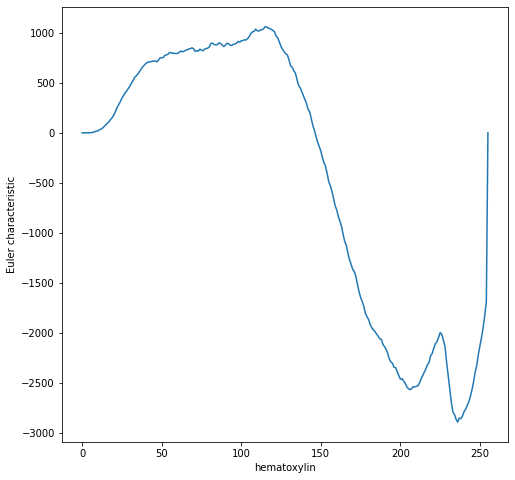

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(range(0, 256), X[0])
#plt.tight_layout()
plt.xlabel('hematoxylin')
plt.ylabel('Euler characteristic')
plt.savefig('1_1_ECC_hema.pdf')

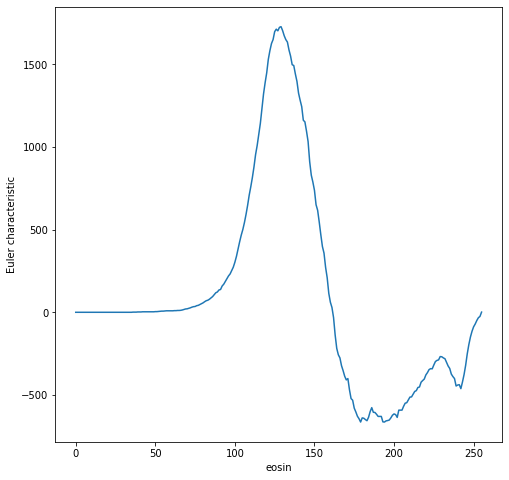

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(range(0, 256), fill_up_ECC(eosin[0][0]))
#plt.tight_layout()
plt.xlabel('eosin')
plt.ylabel('Euler characteristic')
plt.savefig('1_1_ECC_eosin.pdf')

hema


  0%|          | 0/5182 [00:00<?, ?it/s]

(5182, 256)
(5182,)
(2567, 256) (2351, 256) (264, 256)
SVM NO RESAMPLE
grade3 vs grade4
svm accuracy: 0.7648678861788618


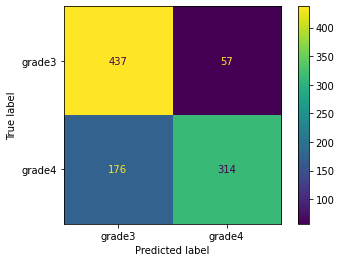

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for data, l in [[hema, 'hema']]: # ,[eosin, 'eosin'], [grayscale, 'grayscale']]:
    print(l)
    X = np.array([fill_up_ECC(ecc) for ecc, label in tqdm(data)])
    y = np.array([label for ecc, label in data])

    print(X.shape)
    print(y.shape)

    # Create holder arrays to load in landscapes of each cell type
    grade3 = X[y == 3]
    grade4 = X[y == 4]
    grade5 = X[y == 5]

    print(grade3.shape, grade4.shape, grade5.shape)

    print('SVM NO RESAMPLE')

    test_split = 0.2
    nbr_of_repeats = 100


    for X, y, label in zip(
        [
            np.vstack([grade3, grade4]),
            # np.vstack([grade5, grade4]),
            # np.vstack([grade5, grade3]),
            # np.vstack([grade5, grade4, grade3]),
        ],
        [
            np.array(["grade3"] * len(grade3) + ["grade4"] * len(grade4)),
            # np.array(["grade5"] * len(grade5) + ["grade4"] * len(grade4)),
            # np.array(["grade5"] * len(grade5) + ["grade3"] * len(grade3)),
            # np.array(["grade5"] * len(grade5) + ["grade4"] * len(grade4) + ["grade3"] * len(grade3)),
        ],
        ["grade3 vs grade4", 
        #  "grade4 vs grade5", "grade3 vs grade5", "3way",
        ],
    ):

        print(label)
        test_accuracy_SVM = []
        
        for i in tqdm(range(nbr_of_repeats)):
            
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_split, random_state=i)
            
            
            SVM_classifier = svm.SVC(kernel='rbf', 
                                    class_weight='balanced', 
                                    C=1,
                                    random_state=42)
            SVM_classifier.fit(X_train, y_train)
            test_accuracy_SVM.append(SVM_classifier.score(X_test, y_test))


        print("svm accuracy:", np.mean(test_accuracy_SVM))
        
        predictions = SVM_classifier.predict(X_test)
        cm = confusion_matrix(y_test, predictions, labels=SVM_classifier.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=SVM_classifier.classes_)
        disp.plot()

        plt.show()

In [ ]:
np.std(test_accuracy_SVM) / 10

0.001103160119680268

LDA NO RESAMPLE
hema


  0%|          | 0/5182 [00:00<?, ?it/s]

(5182, 256)
(5182,)
(2567, 256) (2351, 256) (264, 256)
SVM NO RESAMPLE
grade3 vs grade4
lda accuracy: 0.7207317073170729


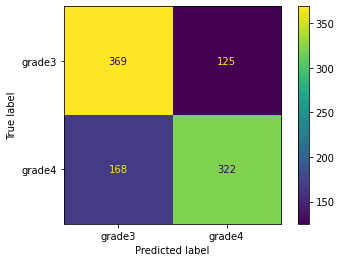

In [ ]:
print('LDA NO RESAMPLE')

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_split = 0.2
nbr_of_repeats = 100


for data, l in [[hema, 'hema']]: # ,[eosin, 'eosin'], [grayscale, 'grayscale']]:
    print(l)
    X = np.array([fill_up_ECC(ecc) for ecc, label in tqdm(data)])
    y = np.array([label for ecc, label in data])

    print(X.shape)
    print(y.shape)

    # Create holder arrays to load in landscapes of each cell type
    grade3 = X[y == 3]
    grade4 = X[y == 4]
    grade5 = X[y == 5]

    print(grade3.shape, grade4.shape, grade5.shape)

    print('SVM NO RESAMPLE')

    test_split = 0.2
    nbr_of_repeats = 100


    for X, y, label in zip(
        [
            np.vstack([grade3, grade4]),
            # np.vstack([grade5, grade4]),
            # np.vstack([grade5, grade3]),
            # np.vstack([grade5, grade4, grade3]),
        ],
        [
            np.array(["grade3"] * len(grade3) + ["grade4"] * len(grade4)),
            # np.array(["grade5"] * len(grade5) + ["grade4"] * len(grade4)),
            # np.array(["grade5"] * len(grade5) + ["grade3"] * len(grade3)),
            # np.array(["grade5"] * len(grade5) + ["grade4"] * len(grade4) + ["grade3"] * len(grade3)),
        ],
        ["grade3 vs grade4", 
        #  "grade4 vs grade5", "grade3 vs grade5", "3way",
        ],
    ):

        print(label)
        test_accuracy_lda = []
        
        for i in tqdm(range(nbr_of_repeats)):
            
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_split, random_state=i)
            
            
            ldr_classifier = LinearDiscriminantAnalysis()
            ldr_classifier.fit(X_train, y_train)
            test_accuracy_lda.append(ldr_classifier.score(X_test, y_test))


        print("lda accuracy:", np.mean(test_accuracy_lda))
        
        predictions = ldr_classifier.predict(X_test)
        cm = confusion_matrix(y_test, predictions, labels=ldr_classifier.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=ldr_classifier.classes_)
        disp.plot()

        plt.show()

# NN

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm.notebook import tqdm

## Network

In [ ]:
### Define the network class
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No, dropout_prob=0):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fcOut = nn.Linear(Nh2, No)
        
        # Sigmoid
        #self.act = nn.Sigmoid()
        # Leaky ReLu
        self.act = nn.LeakyReLU()

        self.drop = nn.Dropout(p = dropout_prob)

    def forward(self, x):
        
        x = self.drop(x)
        x = self.act(self.fc1(x))
        x = self.drop(x)
        x = self.act(self.fc2(x))
        x = self.drop(x)
        out = self.fcOut(x)

        return out

## Train and Evaluate functions

In [ ]:
def train_NN(net, num_epochs, X_train, y_train, X_test, y_test,
             lr = 1e-4, wd = 1e-5, batch_size=100):
    train_loss_log = []
    test_loss_log = []

    # we can use the GPU, thanks google!
    device = torch.device("cpu")
    # Move all the network parameters to the selected device 
    net.to(device)

    ### Define the loss function
    loss_fn = nn.CrossEntropyLoss()

    ### Define an optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

    # create the dataloaders
    train_data = torch.utils.data.TensorDataset(torch.tensor(X_train).float(), 
                                                torch.tensor(y_train))
    test_data = torch.utils.data.TensorDataset(torch.tensor(X_test).float(), 
                                            torch.tensor(y_test))

    train_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size=batch_size,
                                            shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data,
                                            batch_size=batch_size,
                                            shuffle=False)

    for num_epoch in range(num_epochs):
        # Training
        net.train() # Training mode (e.g. enable dropout)
        # Eventually clear previous recorded gradients
        optimizer.zero_grad()

        train_loss = []

        for batch_idx, (train_data, train_label) in enumerate(train_loader):
            # Eventually clear previous recorded gradients
            optimizer.zero_grad()

            # forward + backward + optimize

            outputs = net(train_data.to(device))
            loss = loss_fn(outputs, train_label.to(device))
            train_loss.append(loss.data.item())

            loss.backward()
            optimizer.step()

        avg_train_loss = np.mean(train_loss)


        # Validation
        net.eval() # Evaluation mode (e.g. disable dropout)
        test_loss = []
        with torch.no_grad(): # No need to track the gradients
            for batch_idx, (test_data, test_label) in enumerate(test_loader):
                outputs = net(test_data.to(device))
                # Evaluate loss
                loss = loss_fn(outputs, test_label.to(device))
                test_loss.append(loss.data.item())

            avg_test_loss = np.mean(test_loss)

        # Print loss
        # print('Epoch', num_epoch + 1)
        # print('Training loss     :{}'.format(avg_train_loss))
        # print('Validation loss   :{}\n'.format(avg_test_loss))
            
        # Log
        train_loss_log.append(avg_train_loss)
        test_loss_log.append(avg_test_loss)

    return net, train_loss_log, test_loss_log


In [ ]:
def plot_loss(train_loss_log, test_loss_log):
    # Plot losses
    plt.close('all')
    plt.figure(figsize=(8, 6))


    cmap = plt.get_cmap("tab10")

    plt.semilogy(train_loss_log, 
                    label='Train')
    plt.semilogy(test_loss_log, 
                    # an underscore in the label exclude it from legend
                    label='Test')

    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.title('Final Model', fontsize=18)
    plt.grid()
    plt.legend(fontsize=14)
    plt.tight_layout()

    #plt.savefig("final.pdf")
    #files.download("final.pdf")
    plt.show()

In [ ]:
def test_accuracy(net, X_test, y_test):
    input_test = torch.tensor(X_test).float()
    label_test = torch.tensor(y_test)

    net.eval()

    with torch.no_grad():
        outputs = net(input_test)
        softmax = nn.functional.softmax(outputs, dim = 1)
        predicted_label = np.argmax(softmax, axis=1).numpy()

    return sum((label_test.numpy() == predicted_label)*1)/len(label_test), label_test, predicted_label

In [ ]:
def NN_k_fold(num_folds, X, y, par):
    # K_FOLD parameters
    kf = KFold(n_splits=num_folds,
            shuffle=True,
            random_state=42)

    accuracy_log = []

    num_classes = len(pd.unique(y))
    accuracy_classes = {}
    for c in range(num_classes):
        accuracy_classes[c] = []

    for fold, (train_idx, test_idx) in tqdm(enumerate(kf.split(X, y))):
        # initialize the net
        num_classes = len(pd.unique(y))
        net = Net(256, 128, 64, num_classes, dropout_prob=0)

        net, train_log, test_log = train_NN(net, par['num_epochs'], 
                            X[train_idx], y[train_idx], 
                            X[test_idx], y[test_idx],
                            par['lr'], par['wd'],
                            batch_size=len(train_idx))

        accu, true_labels, predicted_labels = test_accuracy(net, X[test_idx], y[test_idx])
        accuracy_log.append(accu)
        print("\t", accu)

        # confusion matrix
        cf_matrix = confusion_matrix(true_labels, predicted_labels)
        cf_matrix_norm = cf_matrix / cf_matrix.sum(axis=1)

        for c in accuracy_classes:
            accuracy_classes[c].append(cf_matrix_norm[c,c])

        #plot_loss(train_log, test_log)

    return accuracy_log, accuracy_classes

## Binary

In [ ]:
import pickle

with open('pkls/ECC_grayscale.pkl', 'rb') as f:
    grayscale = pickle.load(f)

In [ ]:
X = np.array([fill_up_ECC(ecc) for ecc, label in tqdm(grayscale)])
y = np.array([label for ecc, label in grayscale])

print(X.shape, y.shape)

# Create holder arrays to load in landscapes of each cell type
grade3 = X[y == 3]
grade4 = X[y == 4]
grade5 = X[y == 5]

X_34 = np.vstack([grade3, grade4])
y_34 = np.array([0] * len(grade3) + [1] * len(grade4))
print(X_34.shape, y_34.shape)


In [ ]:
train_par = {'num_epochs': 500,
             'lr': 5e-4,
             'wd': 1e-4}

acc_list, acc_classes = NN_k_fold(10, X_34, y_34, train_par)

acc = np.mean(acc_list)
std = np.std(acc_list, ddof=1)

to_print.append([acc, std])

print("mean accuracy :  {} +- {} \n".format(acc, std))

for c in acc_classes:
    acc = np.mean(acc_classes[c])
    std = np.std(acc_classes[c], ddof=1)
    print("class {} : {} +- {}".format(c, acc, std))
    
    to_print.append([acc, std])
    
print("")

for i, item in enumerate(to_print):
    print("{}  &  {:3.2f} $\pm$ {:2.2f}  \\\\".format(i-1, item[0]*100, item[1]*100))